In [3]:
#Customer Intensification (overtime)
import pyodbc as pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#configuration
pd.set_option('float_format', '{:.0f}'.format)
mydateparser = lambda x: pd.datetime.strptime(x, "%d/%m/%y")
plt.rcdefaults()

#connections
server = 'tcp:ausse-nzte-sqlrepp1.database.windows.net'
database = 'prdCRMReport'
driver = '{ODBC Driver 17 for SQL Server}'
username = 'prdCRMReport_Admin_Read'
password = '?ZvEHun3PE$E793G'

#assign cluster by percentile
def cluster(x):
    if x < 4:           #percentile <34
        return 0
    elif 4 <= x < 12 :  #percentile <67
        return 1
    elif x >= 12:
        return 2

#assign cluster by outcome_growth
def outcome_cluster(x):
    if -9999< x < 0:           #decrease 
        return "decreasing"
    elif x == 0:         #remain the same
        return "no change"
    elif 0 < x < 999:   #increase
        return "increasing"
    elif x ==9999 :       #1st time
        return "1st time"
    elif x == -9999 :       #1st time
        return "never had at all"


#assign cluster lebel 
def cluster_label(x):
    if x == 0 :           return "Low"
    elif x == 1 :         return "Medium"
    elif x == 2 :         return "High"
    

#parameters: to sql 
# snapshot period to compare
snapshot_start_date ='2020-03-02'
snapshot_end_date = '2020-10-12'

# how far back before the snapshot we want to look
mth_to_snapshot = -12
mth_to_snapshot_oc = -36

#Folder that hold outputs
outDir  = 'data//'
#exported_date = pd.to_datetime("today").strftime("%Y%m%d")
exported_date = pd.to_datetime(snapshot_end_date).strftime("%Y%m%d")

#snapshot to analyse
read_file_date = exported_date


In [33]:
cnxn = pyodbc.connect('DRIVER=' + driver +';SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

sql_ogt_snapshots = """
            
DECLARE
@newFocusCutoffDate as Date =  '2020-03-01', -- use this date as a start date of all types of engagement for this analysis
@cohort1 as date = '2020-03-01',
@cohort2 as date = '2020-07-01',
@cohort3 as date = '2020-10-01',
@snapshotStart as date = '""" + snapshot_start_date + """',
@snapshotEnd as date =  '""" + snapshot_end_date + """',
@actionStartDate as int = """ + str(mth_to_snapshot) + """ ;

with cte_objectives  as (
		select sum(obj.[Objective Count])                                                       as [objective_all]
            , sum(iif(obj.[Objective Created On Date] > org.[Organisation Entry To Segment Date] 
                    , obj.[objective count],0)   )                                               as [objective_aftr]
		    , obj.[Objective Organisation key]
			, obj.[SnapshotNZDate]
        from [CRM_Snapshot].[objectives] obj
                left join [crm].[organisations] org
                    on obj.[objective organisation key] = org.[organisation key]
        where not [obj].[objective status] in  ( 'withdrawn', 'on hold')
		and obj.[SnapshotNZDate] in ( @snapshotStart, @snapshotEnd)
      	group by obj.[Objective Organisation Key], obj.[SnapshotNZDate]
        
), cte_investments as (
        Select  count (distinct  invd.[Investment Opportunity GUID]) + 0													as [Inv Deals]
				, [Customer GUID], inv.[SnapshotNZDate]            
        From [INV_Snapshot].[INV_Investment_Fact_Header] inv
            Left Join [INV].[INV_Investment_Deals_Header] invd
                On inv.[investment Opportunity GUID] = invd.[Investment Opportunity GUID]            		
        Where invd.[Investment Status] in ('Engaged')
		and inv.[SnapshotNZDate] in ( @snapshotStart, @snapshotEnd)
        Group By [Customer GUID] , inv.[SnapshotNZDate]		
), cte_iPlanLast12Months as (
			select count(distinct(p.[Project ID]) )as [iplan_all]
				,pr.[Project Registration Organisation Key] 
				, pr.[SnapshotNZDate]
			from [CRM_Snapshot].[ProjectRegistrations] pr
				left join [CRM_Snapshot].[ProjectSessions] ps
					on pr.[Project Session Key] = ps.[Project Session Key]
					and ps.[SnapshotNZDate] = pr.[SnapshotNZDate]
				inner join [CRM_Snapshot].[Projects] p
					on p.[Project Key] = ps.[Project Key]
					and p.[SnapshotNZDate] = ps.[SnapshotNZDate]
			where p.[Project Budget Source] = 'iPlan'
			and ps.[Project Session Start Date] >= @snapshotStart --DATEADD(dd,DATEDIFF(dd,0,ps.[SnapshotNZDate])-365,0)
			and pr.[Project Registration Organisation Key]  is not null
			and pr.[Project Registration Attended On Date] is not null
			and pr.[snapshotnzDate] in ( @snapshotStart, @snapshotEnd)
            group by pr.[Project Registration Organisation Key], pr.[SnapshotNZDate]
), cte_IGF as (
		select count(*) as [active IGFs], igf.[Fund Organisation Key]
			, igf.[SnapshotNZDate]
		from [IGF_Snapshot].[Funds] igf
		where igf.[fund status] = 'Active'
		and [Fund Type Name]  like 'IGF%' 
		and  igf.[SnapshotNZDate]  in ( @snapshotStart, @snapshotEnd)
		group BY igf.[Fund Organisation Key], igf.[SnapshotNZDate]
), cte_actions_by_type as (
     select  count (distinct(a.[Action ID]))                                                as [actions_all]
                ,count(distinct(iif(a.[action start date] > org.[organisation Entry to Segment Date]
                        , a.[Action ID]
                        , null) ))                                                          as [actions_aftr]
		        , a.[action Organisation key]
                , a.[action service Type]
				, a.[snapshotnzDate]
        from [CRM_Snapshot].[Actions] a
            left join [crm].[organisations] org
                on a.[Action Organisation Key] = org.[organisation key]
        where not a.[Action Status] in ( 'withdrawn', 'on hold')
        and (a.[action Start Date] >= dateadd(m,  @actionStartDate, a.snapshotnzDate)  
			or a.[action End Date] >= dateadd(m,  @actionStartDate, a.[SnapshotNZDate]) )
		and a.[SnapshotNZDate]  in ( @snapshotStart, @snapshotEnd)
        group by a.[action organisation Key], a.[action service Type], a.[snapshotnzDate]
), cte_service_actions as (
	select sum(a.[actions_all]) 		as [actions_all]
	, sum(a.[actions_aftr]) 			as [actions_aftr]
	, a.[Action Organisation Key]
	, a.[snapshotnzdate]
	from cte_actions_by_type a	
	where a.[Action Service Type] is not null
	group by a.[Action Organisation Key], a.[snapshotnzDate]
), cte_actions as (
	select sum(a.[actions_all]) 		as [actions_all]
	, sum(a.[actions_aftr]) 			as [actions_aftr]
	, a.[Action Organisation Key]
	, a.[snapshotnzDate]
	from cte_actions_by_type a	
	group by a.[Action Organisation Key], a.[snapshotnzDate]
)

-- --*********************** ALL OBJECTIVES ***********************
-- select * 
-- from cte_objectives
-- where [Objective Organisation Key]  = '00B75B10-C9F5-DF11-A1F6-02BF0ADC02DB'
--*********************** ALL OUTCOMES ***********************
-- select * from cte_actions
-- where [action organisation key] = '00635574-E57E-EA11-A811-000D3AD1972A'
--*********************** ALL OUTCOMES ***********************
-- select cte_o.*, o.* 
-- from cte_outcomes cte_o 
--     left join [crm].[Outcomes] o on o.[Outcome Organisation Key] = cte_o.[Outcome Organisation Key]
--         and o.[Outcome Status] = 'Complete'
--         and o.[outcome approval Date] >= @cohort1
--     inner join [crm].[Organisations] org
--         on cte_o.[Outcome Organisation Key] = org.[Organisation Key]
--         and org.[Organisation NZTE Segment] = 'Focus'
--*********************** SUMMARY (TEST)***********************
-- select org.[Organisation Key]
-- 	, org.[Organisation Legal Name]
-- 	   , a.[actions_all]							as [all_actions]
-- 	   , cte_sa.[actions_all]        				as [service_actions_all]
-- from crm.[Organisations] org
-- 	left join cte_actions a
-- 		on a.[Action Organisation Key] = org.[organisation key]
-- 			-- 	-- Services Actions
-- 	left join cte_service_actions cte_sa
--         on cte_sa.[Action Organisation Key] = org.[organisation key]		
-- where  	 org.[Organisation NZTE Segment] = 'Focus'
--      and org.[Organisation Key] = '94E2EB8B-C8F5-DF11-A1F6-02BF0ADC02DB'
-- -- group by org.[Organisation Key]
-- -- 	, org.[Organisation Legal Name]

--*********************** SUMMARY ***********************

SELECT org.[Organisation Key]
	, org.[Organisation Legal Name]
	, org.[Organisation Entry To Segment Date]
	, org.[Organisation Maori Customer]												as [Maori Customer]
	, org.[Organisation NZTE Sector]												as [Sector]
	, org.[Organisation Age in Focus (Months)]										as [Age in Focus (Month)]
	, IIF(org.[Organisation Entry To Segment Date] >= @newFocusCutoffDate, 1, 0 )	as [Is New Focus]
    , case 
        when org.[Organisation Entry To Segment Date] < @cohort1    
            then 'Cohort 1'
        when org.[Organisation Entry To Segment Date] >= @cohort1 and org.[Organisation Entry To Segment Date] < @cohort2    
            then 'Cohort 2'
        when org.[Organisation Entry To Segment Date] >= @cohort2 and org.[Organisation Entry To Segment Date] < @cohort3   
            then 'Cohort 3'
        when org.[Organisation Entry To Segment Date] >= @cohort3
            then 'Cohort 4'
        else 'undefined'
        end as [cohort]
	, o.[Organisation NZTE Segment]									as [Segment]
	, cte_iplan.[iplan_all]                                 			as [iPlan Last 12 Months]
	--, cte_a.[actions_all]               							as [actions_all]
    , cte_a.[actions_aftr]               							as [actions_aftr]
    , cte_sa.[actions_all]               							as [service_actions_all]
    , cte_sa.[actions_aftr]               							as [service_actions_aftr]
	, cte_o.[objective_all]										    as [Objectives_all]
    , cte_o.[objective_aftr]										as [Objectives_aftr]
	, cte_IGF.[active IGFs]											as [Active IGFs]
	, cte_inv.[Inv Deals]	 										as [Investment Deals]
	--, org.[Organisation Ownership Category]
	, o.[SnapshotNZDate]											as [SnapshotNZDate]
	--, coalesce(cpeLast6Mths.[Session Count] , 0) 						as [Customer Portal Sessions Last 6 Months]
FROM [CRM_Snapshot].[Organisations] org
	left join [CRM_Snapshot].[Organisations] o
		on org.[Organisation Key] =  o.[Organisation Key]
        and o.[SnapshotNZDate] in ( @snapshotStart, @snapshotEnd)
		--and (o.[SnapshotNZDate] >= '2019-07-01'     and o.SnapshotNZDate <> '2020-04-28') -- excluding mistaken snapshot.5
	left join cte_investments cte_inv
		on cte_inv.[Customer GUID] = org.[organisation key]
		and o.[SnapshotNZDate] = cte_inv.[SnapshotNZDate]
	-- Objective
	left join cte_objectives cte_o
        on cte_o.[Objective Organisation key] = org.[organisation key]
		and o.[SnapshotNZDate] = cte_o.[SnapshotNZDate] 
	-- All Actions
	left join cte_actions cte_a
        on cte_a.[Action Organisation Key] = org.[organisation key]
	 	and cte_a.[SnapshotNZDate] = o.[SnapshotNZDate]
	-- Services Actions
	left join cte_service_actions cte_sa
        on cte_sa.[Action Organisation Key] = org.[organisation key]
		and cte_sa.[SnapshotNZDate] = o.[SnapshotNZDate]   
	-- IGF
	left join cte_IGF 
		on cte_IGF.[Fund Organisation key] = org.[organisation key]					
	 	and cte_igf.[SnapshotNZDate] = o.[SnapshotNZDate]
	-- iPlans activities
	left join cte_iPlanLast12Months cte_iplan
		on cte_iplan.[Project Registration Organisation Key]  =  org.[organisation key]
		and cte_iplan.[SnapshotNZDate] = o.[SnapshotNZDate] 
	-- Customer Portal Engagement
	--left join (
	--		select count(distinct cp.[Session ID])   as [Session Count]
	--				, c.[Contact Organisation Key]
	--		from [CRM].[temp_CustomerPortal] cp
	--			left join [CRM].[Contacts] c
	--				on cp.[Contact Key] = c.[Contact Key]
	--		where cp.[User Type] = 'External'		
	--		and cp.[Activity UTC Date] >= @Last6MthDate
	--		group by c.[Contact Organisation Key]
	--) cpeLast6Mths
	--	on cpeLast6Mths.[Contact Organisation Key] = org.[organisation key]
where 
	 org.[Organisation NZTE Segment] = 'Focus' and org.[SnapshotNZDate] = @snapshotEnd
     --and org.[Organisation Key] = '00B75B10-C9F5-DF11-A1F6-02BF0ADC02DB'
order by  org.[Organisation Legal Name]
, o.[SnapshotNZDate]
            """
ogt_snapshot = pd.read_sql(sql_ogt_snapshots, cnxn)
##############################################################################################################

outfilePath = outDir + "ogt_engagement_snapshot" + exported_date + ".csv"

(ogt_snapshot.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)
##############################################################################################################
#actions
##############################################################################################################
actions_sql = """
DECLARE
@newFocusCutoffDate as Date =  '2020-03-01', -- use this date as a start date of all types of engagement for this analysis
@cohort1 as date = '2020-03-01',
@cohort2 as date = '2020-07-01',
@snapshotStart as date = '""" + snapshot_start_date + """',
@snapshotEnd as date =  '""" + snapshot_end_date + """',
@actionStartDate as int = """ + str(mth_to_snapshot) + """ ;

with cte_actions_by_type as (
     select  count (distinct(a.[Action ID]))                                                as [actions_all]
                ,count(distinct(iif(a.[action start date] > org.[organisation Entry to Segment Date]
                        , a.[Action ID]
                        , null) ))                                                          as [actions_aftr]
		        , a.[Action Organisation Key]
                , a.[Action Service Type]
				, a.[SnapshotNZDate]
                , a.[action status]
        from [CRM_Snapshot].[Actions] a
            left join [crm].[organisations] org
                on a.[Action Organisation Key] = org.[organisation key]
        where not a.[Action Status] in ( 'withdrawn', 'on hold')
        -- all actions in the last 12 months before snapshotDate (both begin and end)
		and (a.[action Start Date] >= dateadd(m,  @actionStartDate, a.[SnapshotNZDate])   
			or a.[action End Date] >= dateadd(m,  @actionStartDate, a.[SnapshotNZDate]) )
		and a.[SnapshotNZDate]  in ( @snapshotStart, @snapshotEnd)
        group by a.[action organisation Key], a.[action service Type], a.[snapshotnzDate], a.[action status]
), cte_service_actions as (
	select sum(a.[actions_all]) 		as [actions_all]
	, sum(a.[actions_aftr]) 			as [actions_aftr]
	, a.[Action Organisation Key]
	, a.[snapshotnzdate]
	from cte_actions_by_type a	
	where a.[Action Service Type] is not null
	group by a.[Action Organisation Key], a.[SnapshotNZDate]
), cte_actions as (
	select sum(a.[actions_all]) 		as [actions_all]
	, sum(a.[actions_aftr]) 			as [actions_aftr]
	, a.[Action Organisation Key]
	, a.[snapshotnzDate]
	from cte_actions_by_type a	
	group by a.[Action Organisation Key], a.[SnapshotNZDate]
), cte_actions_by_status as (
    select sum(a.[actions_all])         as [actions_all]
    , a.[Action Organisation Key]
	, a.[SnapshotNZDate]
    , a.[action status]
    from cte_actions_by_type a
    group by a.[action organisation key], a.[SnapshotNZDate], a.[action status]
)
select * from cte_actions_by_type
"""
ogt_actions_snapshot = pd.read_sql(actions_sql, cnxn)
##############################################################################################################

outfilePath = outDir + "ogt_actions_snapshot" + exported_date + ".csv"

(ogt_actions_snapshot.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)
##############################################################################################################
#outcomes (note: some outcomes were entered back date, so it might not show accurately in the snapshot tables)
#other outcomes stages eg. referal for last 3 years is less than 40 ( <0.2%) and none for the last 2 years so we exclude from this analysis
##############################################################################################################
outcomes_sql = """
DECLARE
@newFocusCutoffDate as Date =  '2020-03-01', -- use this date as a start date of all types of engagement for this analysis
@cohort1 as date = '2020-03-01',
@cohort2 as date = '2020-07-01',
@snapshotStart as date = '""" + snapshot_start_date + """',
@snapshotEnd as date =  '""" + snapshot_end_date + """',
@monthsBeforeSnapshot as int =  '""" + str(mth_to_snapshot_oc) + """' ;

select sum(oc.[outcome calculated amount (nzd)])                                                               	as [Deals$_all]
			, count(iif(oc.[Outcome Stage] = 'IGO', oc.[outcome id],  null ))                                 	as [IGOs_all] 
            , count(iif(oc.[Outcome Stage] = 'Deal', oc.[outcome id], null))                                   	as [Deals_all]
            , sum(oc.[outcome count])                                                                          	as [Outcome_all]
            , count(iif(oc.[Outcome Stage] = 'Introduction', oc.[outcome id], null))                           	as [Intro_all]
            , count(iif(oc.[Outcome Stage] = 'Lead', oc.[outcome id], null))                                   	as [Leads_all]
            , sum(IIF (oc.[outcome Approval Date]  > org.[Organisation Entry To Segment Date] 
                        , oc.[outcome calculated amount (nzd)], 0))                                                         as [Deals$_aftr] 
            , count(IIF (oc.[Outcome Stage] = 'Deal' and oc.[outcome Approval Date]  > org.[Organisation Entry To Segment Date] 
                        ,  oc.[outcome id] ,null))						                                                    as [Deals_aftr] 		
			, count(iif(  oc.[Outcome Stage] = 'IGO' and oc.[outcome Approval Date]  > org.[Organisation Entry To Segment Date]
                        , oc.[outcome id] ,null))                                                                           as [IGOs_aftr]   
			, sum(iif(  oc.[outcome Approval Date]  > org.[Organisation Entry To Segment Date]
                        , oc.[outcome count] ,0))     																		 as [Outcome_aftr]
			, count(iif(oc.[Outcome Stage] = 'Introduction' and oc.[outcome Approval Date]  > org.[Organisation Entry To Segment Date]
                        , oc.[outcome id] ,null))                                                                          	as [Intro_aftr]
            , count(iif(  oc.[Outcome Stage] = 'Lead' and oc.[outcome Approval Date]  > org.[Organisation Entry To Segment Date]
                        , oc.[outcome id] ,null))                                                                           as [Leads_aftr]
            , oc.[outcome organisation key]
            , oc.[SnapshotNZDate]
            from [CRM_Snapshot].[Outcomes] oc
                left join [crm].[organisations] org
                    on oc.[outcome organisation key] = org.[organisation key]
            where oc.[Outcome Status] = 'Complete'
			and (oc.[outcome approval Date] >= dateadd(m,  @monthsBeforeSnapshot, oc.snapshotnzDate)  
			    or oc.[Outcome Created Date] >= dateadd(m, @monthsBeforeSnapshot, oc.snapshotnzDate) )
            --and  oc.[outcome approval Date] >= @cohort1
			and oc.[SnapshotNZDate] in ( @snapshotStart, @snapshotEnd)
            group by oc.[outcome organisation key], oc.[SnapshotNZDate]
"""
ogt_outcomes_snapshot = pd.read_sql(outcomes_sql, cnxn)
##############################################################################################################
outfilePath = outDir + "ogt_outcomes_snapshot" + exported_date + ".csv"

(ogt_outcomes_snapshot.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)
##############################################################################################################
#IGF 
##############################################################################################################
outcomes_sql = """
DECLARE
@snapshotStart as date = '""" + snapshot_start_date + """',
@snapshotEnd as date =  '""" + snapshot_end_date + """',
@monthsBeforeSnapshot as int =  '""" + str(mth_to_snapshot_oc) + """' ;

select count(*) as [active IGFs]
			, igf.[Fund Organisation Key]			as [Organisation Key]
			,  igf.[Fund Type Name]
            , sum(igf.[Fund Amount Approved])       as [Total_Fund_Amount_Approved]
			, igf.[SnapshotNZDate]
		from [IGF_Snapshot].[Funds] igf
		where igf.[fund status] = 'Active'
		and [Fund Type Name]  like 'IGF%' 
		and  igf.[SnapshotNZDate]  in ( @snapshotStart, @snapshotEnd)
		group BY igf.[Fund Organisation Key], igf.[SnapshotNZDate], igf.[Fund Type Name]
        order by igf.[Fund Organisation Key], igf.[SnapshotNZDate]
"""
ogt_igf_snapshot = pd.read_sql(outcomes_sql, cnxn)
##############################################################################################################
outfilePath = outDir + "ogt_igf_snapshot" + exported_date + ".csv"

(ogt_igf_snapshot.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)
##############################################################################################################
del outfilePath
cnxn.close() 

In [34]:
##############################################################################################################
#Read from a exported file as at certain date
##############################################################################################################
# All FOCUS
ogt_snapshot= pd.read_csv(outDir + 'ogt_engagement_snapshot' + read_file_date + '.csv') #, parse_dates= ["Date"] , date_parser= mydateparser)
#ogt_snapshot= ogt_snapshot.query("SnapshotNZDate == SnapshotNZDate")

# All Actions
actions_snapshot = pd.read_csv(outDir + 'ogt_actions_snapshot' + read_file_date + '.csv')

# All Outcomes
outcomes_snapshot = pd.read_csv(outDir + 'ogt_outcomes_snapshot' + read_file_date + '.csv')

# All IGF
igf_snapshot = pd.read_csv(outDir + 'ogt_igf_snapshot' + read_file_date + '.csv')


In [36]:
igf_snapshot.groupby(by=["Organisation Key", "SnapshotNZDate", "Fund Type Name"]).sum()


NameError: name 'igf_snapshot' is not defined

In [35]:
##############################################################################################################
#Add actions by status and OUTCOMEs to the original Focus dataset
##############################################################################################################
################ add ALL ACTIONS count for each status into the original dataset ################ 
actions_snapshot_pivot = (actions_snapshot.groupby(by =  ["Action Organisation Key",  "SnapshotNZDate", "action status"]).sum().reset_index()
                    .pivot(index = ["Action Organisation Key",  "SnapshotNZDate"], columns= "action status", values = "actions_all") #only actions_all
                    .reset_index()
                    .fillna(0)
                    .rename(columns = {"Action Organisation Key": "Organisation Key"})
                    )
#merge to original dataset
ogt_actions_snapshot = pd.merge(ogt_snapshot, actions_snapshot_pivot, how = "left", on = ["Organisation Key", "SnapshotNZDate"]).fillna(0)
ogt_actions_snapshot["active_actions"]  = ogt_actions_snapshot["Proposed"] + ogt_actions_snapshot["Agreed"]
ogt_actions_snapshot["actions_all"]  = ogt_actions_snapshot["active_actions"] + ogt_actions_snapshot["Complete"]
ogt_actions_snapshot.shape

################ add ALL SERVICE ACTIONS count by type to the original dataset ################ 
service_actions = (actions_snapshot.query("`Action Service Type`.notnull()")
                    .groupby(by =  ["Action Organisation Key",  "SnapshotNZDate", "Action Service Type"]).sum().reset_index()
                    .pivot(index = ["Action Organisation Key",  "SnapshotNZDate"], columns= "Action Service Type", values = "actions_all") 
                    .reset_index()
                    .fillna(0)
                    .rename(columns = {"Action Organisation Key": "Organisation Key"})                
                    )   
#add prefix (svc_) to all services columns
a = [ 'svc_'+str(col)  for col in service_actions.columns[2:]]
service_actions.columns = service_actions.columns[:2].tolist() + a
#service_actions.head()

#merge to original dataset
ogt_actions_snapshot = pd.merge(ogt_actions_snapshot, service_actions, how = "left", on = ["Organisation Key", "SnapshotNZDate"]).fillna(0)

################ add ALL OUTCOME count  to the original dataset ################ 
outcomes_snapshot = outcomes_snapshot.rename(columns = {"outcome organisation key": "Organisation Key"})
ogt_outcomes_snapshot = pd.merge(ogt_actions_snapshot, outcomes_snapshot, how = "left", on = ["Organisation Key", "SnapshotNZDate"]).fillna(0)

#save to file
ogt_snapshot = pd.DataFrame(ogt_outcomes_snapshot)
ogt_snapshot["snapshot_count"] = ogt_snapshot.groupby('Organisation Key')["SnapshotNZDate"].transform('count')

outfilePath = outDir + "ogt_snapshot_summary" + exported_date + ".csv"
(ogt_snapshot.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)

#filter customers that are not in both snapshots. (do after saved to file as we want to leave those merged customers for outcomes reports)
ogt_snapshot = ogt_snapshot.query("snapshot_count == 2")

#prepare dataset
actions_prev = ogt_snapshot.query("`SnapshotNZDate` == '" + snapshot_start_date + "'")
actions_aftr = ogt_snapshot.query("`SnapshotNZDate` == '" + snapshot_end_date + "'")


In [ ]:
ogt_snapshot = pd.DataFrame(ogt_outcomes_snapshot)
ogt_snapshot["snapshot_count"] = ogt_snapshot.groupby('Organisation Key')["SnapshotNZDate"].transform('count')


In [ ]:

#sns.catplot(data = ogt_outcomes_snapshot, x = "cohort",  y = "Outcome_all", hue = "SnapshotNZDate"
                    #, col = "svc_type", col_wrap = 7, order = ["Cohort 1", "Cohort 2", "Cohort 3"]
                    #, kind = "bar", aspect=.8, height =  3                    , estimator = sum                    )
#sns.displot( ogt_outcomes_snapshot, x = "Outcome_all", hue = "SnapshotNZDate", element = "step",  row = "cohort", col = "SnapshotNZDate")

df = pd.DataFrame(ogt_snapshot.groupby(by = ["SnapshotNZDate", "cohort"])["Organisation Key"].nunique()) #.sum("Outcome_all"))#.rank(pct= True)*100
df

In [ ]:
##############################################################################################################
# see the actions by status compared amongst 3 focus groups
##############################################################################################################
pd.set_option('float_format', '{:.2f}'.format)
actions_cols = ["Agreed", "Proposed", "active_actions","Complete","actions_all", "actions_aftr"]
df = ogt_snapshot.groupby(by = ["cohort", "SnapshotNZDate"])[actions_cols].sum().sort_values("cohort")

#print(df)
print(df.pct_change())

sns.boxplot(x ="SnapshotNZDate", y = "actions_all", hue = "cohort", data = ogt_snapshot)



In [ ]:
#Explore in different visuals
#g = sns.FacetGrid(ogt_actions_snapshot, col = "Sector", height = 4, row = "cohort")
#g.map(sns.boxplot, "SnapshotNZDate",   "active_actions" )

#g = sns.FacetGrid(ogt_actions_snapshot, col = "Sector", height = 4, row = "SnapshotNZDate")
#g.map(sns.distplot,  "actions_all")

sns.displot(x =  "actions_all" , col = "cohort", data = ogt_actions_snapshot)


#g = sns.FacetGrid(ogt_actions_snapshot, row = "SnapshotNZDate", col = "Sector" , height = 4, hue = "cohort")
#g.map(sns.scatterplot, "Complete",   "active_actions" )

In [ ]:
#plot related actions cols
pd.set_option('float_format', '{:.2f}'.format)

print("************* Before ******************")
print(actions_prev[actions_cols].describe())
print("************* after ******************")
print(actions_aftr[actions_cols].describe())

#boxplot before
fig, axes = plt.subplots(1, 4, sharey = True, figsize = (10,5))
fig.suptitle('5 related action columns')

for i in range(len([0,1,2,3])):
    sns.boxplot(ax = axes[i], y = actions_prev[actions_cols[i]])
    axes[i].set_title(actions_cols[i])
#boxplot after
fig, axes = plt.subplots(1, 4, sharey = True, figsize = (10,5))
fig.suptitle('5 related action columns')

for i in range(len([0,1,2,3])):
    sns.boxplot(ax = axes[i], y = actions_aftr[actions_cols[i]])
    axes[i].set_title(actions_cols[i])

#distribution before
fig, axes = plt.subplots(1, 4, sharey = True, figsize = (5,5))
fig.suptitle('5 related action columns')

for i in range(len([0,1,2,3])):
    sns.distplot(actions_prev[actions_cols[i]], ax = axes[i])
    axes[i].set_title(actions_cols[i])


In [ ]:
# all actions , all statuses
df = ogt_snapshot[['Organisation Key','Organisation Legal Name','SnapshotNZDate', "actions_all"]]
df = pd.pivot_table(df, index = "Organisation Legal Name", values = "actions_all", columns = "SnapshotNZDate").reset_index()
df = df.rename(columns={snapshot_start_date: "Prev", snapshot_end_date:"Aftr"}).fillna(0)

my_range=range(1,len(df.index)+1)

#plot dumbell
plt.figure(figsize=(15, 50))
plt.hlines(y= my_range, xmin=df['Prev'], xmax=df['Aftr'], color='grey', alpha=0.4)
plt.scatter(x = df['Prev'], y = df["Organisation Legal Name"], color='skyblue', alpha=1) #, label='Prev')
plt.scatter(df['Aftr'], df["Organisation Legal Name"], color='green', alpha=0.4 ) #label='Aftr')
plt.legend()
 
 
# Add title and axis names
#plt.yticks(df, df['Organisation Legal Name'])
plt.title("Comparison of the value 1 and the value 2", loc='left')
plt.xlabel('Value of the variables')
plt.ylabel('Group')




In [ ]:
# all actions (all and after segmented in)
df = ogt_snapshot[['Organisation Key','Organisation Legal Name','SnapshotNZDate', "actions_all", "actions_aftr"]]
df = pd.pivot_table(df, index = ["Organisation Key","Organisation Legal Name"], values = ["actions_all","actions_aftr"], columns = "SnapshotNZDate").reset_index()
df = df.rename(columns={snapshot_start_date: "Prev", snapshot_end_date:"Aftr"}).fillna(0)
df.columns = [f'{i}_{j}' for  i, j in df.columns]

my_range=range(1,len(df.index)+1)
#plot dumbell
plt.figure(figsize=(15, 50))
plt.hlines(y= my_range, xmin=df['actions_aftr_Prev'], xmax=df['actions_aftr_Aftr'], color='grey', alpha=0.4)
plt.scatter(x = df['actions_aftr_Prev'], y = df["Organisation Legal Name_"], color='skyblue', alpha=1) #, label='Prev')
plt.scatter(df['actions_aftr_Aftr'], df["Organisation Legal Name_"], color='green', alpha=0.4 ) #label='Aftr')
plt.legend()
 
# Add title and axis names
#plt.yticks(df, df['Organisation Legal Name'])
plt.title("Comparison of the value 1 and the value 2", loc='left')
plt.xlabel('Value of the variables')
plt.ylabel('Group')


In [7]:
#cluster by percentile and generate 2 outputs (long and wide)

#prepare dataset
df_prev = pd.DataFrame(actions_prev)
df_aftr = pd.DataFrame(actions_aftr)

#creating a percentile column for the beginning snapshot
df_prev['percentile_rank'] = actions_prev["actions_all"].rank(pct = True)*100 

#assign cluster for begginning and end periods
df_prev["cluster"] = df_prev.apply(lambda x: cluster(x['actions_all']), axis=1)
df_aftr["cluster"] = df_aftr.apply(lambda x: cluster(x['actions_all']), axis=1)
#assign cluster label 
df_prev["cluster_label"] = df_prev.apply(lambda x: cluster_label(x['cluster']), axis=1)
df_aftr["cluster_label"] = df_aftr.apply(lambda x: cluster_label(x['cluster']), axis=1)

#join the latter cluster back to the prev dataset (long)
df_with_clusters = pd.concat([df_prev, df_aftr])
#join the latter cluster back to the prev dataset (wide)
df = pd.merge(df_aftr, df_prev[["Organisation Key", "cluster", "cluster_label"]] , how = "left", on = "Organisation Key")
#wide : add a new feature to identify the type of engagement change
df["cluster_egm_chng"] = df["cluster_label_y"].str[:1] + df["cluster_label_x"].str[:1]
df_with_clusters = pd.merge(df_with_clusters, df[["Organisation Key", "cluster_egm_chng"]], how = "left", on = "Organisation Key")

#save output to file
outfilePath = outDir + "cluster_prev" + exported_date + ".csv"
(df_prev.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)

#save output to file
outfilePath = outDir + "cluster_aftr" + exported_date + ".csv"
(df.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)

df.shape

(1431, 59)

In [ ]:
df_prev

In [8]:
#cluster by outcome growth
import numpy as np

#analyse from the long format (df_with_clusters)
#all measures wanted to track changes before and after
all_val_col = df_with_clusters.iloc[:,23:53].columns.tolist() 
df_compared = (df_with_clusters.pivot(index = ["Organisation Key", "Organisation Legal Name", "Sector","Organisation Entry To Segment Date", "cohort", "Age in Focus (Month)", "cluster_egm_chng"]
                                    , values = ["cluster", "actions_all", "service_actions_all","Active IGFs"] + all_val_col
                                    , columns = ["SnapshotNZDate"])                                
                                    .reset_index()
                                    .fillna(0)     # leave those without earlier snapshot blank
)

#rename column names 
df_compared.columns = [f'{i}_{j}' for i,j in df_compared.columns]
df_compared.columns = df_compared.columns.str.replace(snapshot_end_date, "aftr")
df_compared.columns = df_compared.columns.str.replace(snapshot_start_date, "prev")


#pct_outcome increase
df_compared["outcome_growth_pct"] = (df_compared["Outcome_all_aftr"] -df_compared["Outcome_all_prev"]) /df_compared["Outcome_all_prev"]*100
df_compared["outcome_growth_pct"] = df_compared["outcome_growth_pct"].replace(np.inf, 9999)
df_compared["outcome_growth_pct"] = df_compared["outcome_growth_pct"].fillna(-9999)
#assign cohort by outcome growth
df_compared["cohort_by_outcome"] = df_compared.apply(lambda x: outcome_cluster(x['outcome_growth_pct']), axis=1)


#save output to file
outfilePath = outDir + "cluster" + exported_date + ".csv"
(df_compared.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)

#df_compared["cohort_by_outcome"].unique()

df_compared.shape

(1431, 77)

In [ ]:
# Prepare Data
df_raw = pd.DataFrame(df_compared)
df_raw["actions_chng"] = df_raw["actions_all_aftr"] - df_raw["actions_all_prev"]
df_raw["scv_actions_chng"] = df_raw["service_actions_all_aftr"] - df_raw["service_actions_all_prev"]
df_raw["outcomes_chng"] = df_raw["Outcome_all_aftr"] - df_raw["Outcome_all_prev"]
df = df_raw[['actions_chng', 'scv_actions_chng','cluster_egm_chng_', 'cluster_prev', 'cluster_aftr', 'Sector_', 'cohort_by_outcome']].groupby('Sector_').apply(lambda x: x.mean())
df.sort_values(['cluster_prev','cluster_aftr'], inplace=True)
df.reset_index(inplace=True)

# Draw plot
fig, ax = plt.subplots(figsize=(5,3), dpi= 80)
ax.hlines(y=df.index, xmin=-15, xmax=20, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=df.index, x=df["actions_chng"], s=75, color='firebrick', alpha=0.7)


# Title, Label, Ticks and Ylim
#ax.set_title('Median changes on Engagment Intensity ', fontdict={'size':15})
ax.set_xlabel('Median changes of engagement Intensity')
ax.set_yticks(df.index)
ax.set_yticklabels(df["Sector_"], fontdict={'horizontalalignment': 'right'})
ax.set_xlim(-10, 15)
plt.show()
print(df)

In [ ]:
# Import Data
df_raw = pd.DataFrame(df_compared)
df_raw["actions_chng"] = df_raw["actions_all_aftr"] - df_raw["actions_all_prev"]
df_raw["outcomes_chng"] = df_raw["Outcome_all_aftr"] - df_raw["Outcome_all_prev"]
df_raw["scv_actions_chng"] = df_raw["service_actions_all_aftr"] - df_raw["service_actions_all_prev"]
#df = pd.DataFrame(df_raw[['cluster_egm_chng_','actions_all_prev', 'actions_all_aftr','actions_chng', "cluster_prev", "cluster_aftr", "cohort_by_outcome"]].groupby('cohort_by_outcome').sum().reset_index())
#df["pct_change"] = (df["actions_chng"]/df["actions_all_prev"] )*100
##df.sort_values(['cluster_prev','cluster_aftr'], inplace=True)
df = df_raw[['actions_chng', 'scv_actions_chng','cluster_egm_chng_', 'cluster_prev', 'cluster_aftr', 'Sector_', 'cohort_by_outcome','actions_all_aftr','actions_all_prev']].groupby('Sector_').apply(lambda x: x.mean()).reset_index()
df.sort_values(['cluster_prev','cluster_aftr'], inplace=True)
df.reset_index(inplace=True)
df

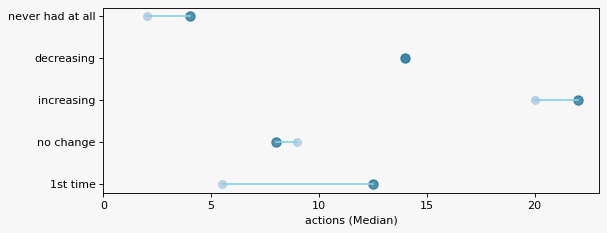

In [11]:
import matplotlib.lines as mlines

# Import Data
df_raw = pd.DataFrame(df_compared)
df_raw["actions_chng"] = df_raw["actions_all_aftr"] - df_raw["actions_all_prev"]
df_raw["scv_actions_chng"] = df_raw["service_actions_all_aftr"] - df_raw["service_actions_all_prev"]
df_raw["outcomes_chng"] = df_raw["Outcome_all_aftr"] - df_raw["Outcome_all_prev"]
df = (df_raw[['actions_chng', 'scv_actions_chng','cluster_egm_chng_'
    , 'cluster_prev', 'cluster_aftr'
    , 'service_actions_all_prev','service_actions_all_aftr'
    ,'actions_all_prev','actions_all_aftr'
    , 'Sector_', 'cohort_by_outcome',"Organisation Key_"]].groupby("cohort_by_outcome")
)

cust_count = df["Organisation Key_"].agg(cust_count="count").reset_index().sort_values("cust_count")
measures = df.apply(lambda x: x.median()).reset_index()

df = pd.merge(cust_count, measures, how = "left", on = "cohort_by_outcome").reset_index()
#declare variable for the measure used in the visual
vis_measure_from = 'actions_all_prev'
vis_measure_to = 'actions_all_aftr'

# Func to draw line segment
def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='skyblue')
    ax.add_line(l)
    return l

# Figure and Axes
fig, ax = plt.subplots(1,1,figsize=(8,3), facecolor='#f7f7f7', dpi= 80)

# Points
ax.scatter(y=df['index'], x=df[vis_measure_from], s=50, color='#a3c4dc', alpha=0.7)
ax.scatter(y=df['index'], x=df[vis_measure_to], s=70, color='#0e668b', alpha=0.7)

# Line Segments
for i, p1, p2 in zip(df['index'], df[vis_measure_from], df[vis_measure_to]):
    newline([p1, i], [p2, i])

# Decoration
ax.set_facecolor('#f7f7f7')
#ax.set_title("Total actions Mar - Oct", fontdict={'size':18})
ax.set(xlim=(0,23), xlabel='actions (Median)')
ax.set_yticks(df.index)
ax.set_yticklabels(df["cohort_by_outcome"], fontdict={'horizontalalignment': 'right'})
plt.show()


In [28]:
df_raw.columns()

TypeError: 'Index' object is not callable

snapshot                                 svc_ori  aftr  prev  diff  diff_pct
0                                 svc_Beachheads    46    23    23       100
12                           svc_Market Research    40    21    19        90
2                                    svc_Digital    24     7    17       243
3         svc_Export Business Continuity Service    23     0    23       inf
17                               svc_Springboard     9     0     9       inf
6                             svc_Fresh Thinking     8    11    -3       -27
14                       svc_Position for Growth     6     1     5       500
7                                 svc_Governance     6     8    -2       -25
15                                     svc_Sales     6     8    -2       -25
4                          svc_Export Essentials     5     3     2        67
18                                  svc_Strategy     5     8    -3       -38
1                                     svc_Design     3     2     1        50

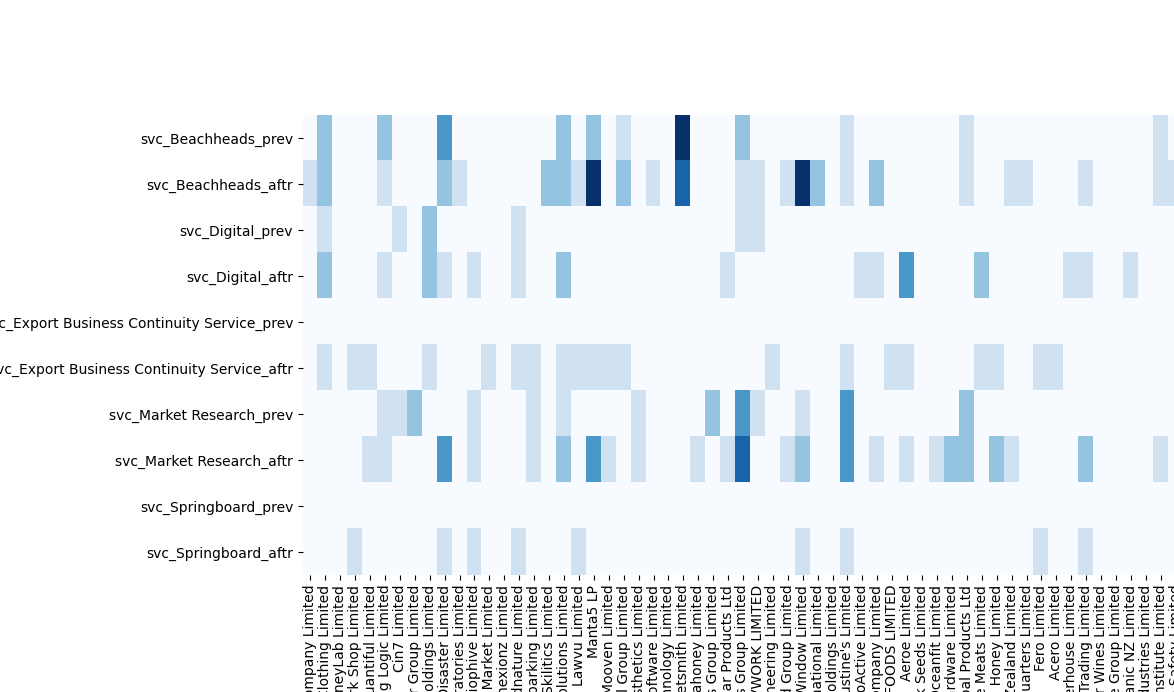

In [32]:
#heatmap showing service used
sel_oc_cohort = "1st time" # 'never had at all' ")# '1st time'") #
#filter only services they used: return service name
#prepare data
df_raw = pd.DataFrame(df_compared)
df_raw = df_raw[df_raw["cohort_by_outcome"] == sel_oc_cohort]

#get all services columns
val_cols = df_raw.columns[15:55]

#sum all services actions to find the most used services
svc_compared = df_raw[val_cols].agg("sum")
#convert to dataframe and add column names
svc_compared = pd.DataFrame({"svc_name": svc_compared.index , "svc_count": svc_compared.values})
#trim out the prev/aftr to find the name of service
svc_compared["svc_ori"] = svc_compared["svc_name"].str[:-5]
#sort
#svc_compared = svc_compared.sort_values("svc_name", ascending = False)

svc_compared =  (svc_compared.groupby(['svc_ori', 'svc_name'])["svc_count"].sum()
        #.sort_index(level= 1, ascending = False)
        .reset_index()
        .assign(snapshot = lambda x: x["svc_name"].str[-4:])  
        .pivot(index = "svc_ori", columns  = "snapshot" ,values = "svc_count").reset_index()
        .assign(diff = lambda x: x["aftr"] - x["prev"])      
        .assign(diff_pct = lambda x: (x["aftr"] - x["prev"]) * 100/x["prev"])      
        .sort_values("aftr", ascending = False)
        )

                
print(svc_compared)#.iloc[:, 0])

#prepare data
src_col  = pd.Series(df_compared.columns)
des_col = tuple(svc_compared.head(5)["svc_ori"].tolist())

col_ind = src_col.str.startswith(des_col).tolist()
df_raw_col = list(src_col[col_ind])
df_raw = df_raw.set_index("Organisation Legal Name_").sort_values("cohort_")

# get the tick label font size
fontsize_pt = 16    # plt.rcParams['ytick.labelsize']
dpi = 72.27

# comput the matrix height in points and inches
matrix_height_pt = fontsize_pt * df_raw.shape[0]
matrix_height_in = matrix_height_pt / dpi

# compute the required figure height 
top_margin = 0.04  # in percentage of the figure height
bottom_margin = 0.04 # in percentage of the figure height
figure_height = matrix_height_in / (1 - top_margin - bottom_margin)

# build the figure instance with the desired height
fig, ax = plt.subplots(
        figsize=( figure_height,5), 
        gridspec_kw=dict(top=1-top_margin, bottom=bottom_margin))


#remove customer with no any of these services
df = pd.DataFrame(df_raw[df_raw_col])
#df = df[(df !=0).any(axis = 1)] #df[(df.T == 0).any(axist = 1)]

#plot
ax = sns.heatmap( df.transpose(), cbar=True, cmap = "Blues"  )

#assign to a new df of top services used and no. customer not used any of these services
df_top_svc = pd.DataFrame(svc_compared.head(5))
df_top_svc["cohort_by_outcome"] =  sel_oc_cohort
df_top_svc["not_use_any_svc"] = df_raw.shape[0] - df.shape[0]  
df_top_svc["ncount"] = df_raw.shape[0]
print(df_top_svc)

#uncomment this code to generate the new dataset and save to file
df_top_svc_combined = pd.DataFrame( df_top_svc) 
#df_top_svc_combined = df_top_svc_combined.append(df_top_svc, ignore_index = True) 
outfilePath = outDir + "top_svc_used" + exported_date + ".csv"
(df_top_svc_combined.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)

In [752]:

df =  (svc_compared.groupby(['svc_ori', 'svc_name'])["svc_count"].sum()
        #.sort_index(level= 1, ascending = False)
        .reset_index()
        .assign(snapshot = lambda x: x["svc_name"].str[-4:])  
        .pivot(index = "svc_ori", columns  = "snapshot" ,values = "svc_count").reset_index()
        .assign(diff = lambda x: x["aftr"] - x["prev"])      
        .assign(diff_pct = lambda x: (x["aftr"] - x["prev"]) * 100/x["prev"])      
        .sort_values("aftr", ascending = False)
        )

df


snapshot,svc_ori,aftr,prev,diff,diff_pct
0,svc_Beachheads,919,717,202,28
12,svc_Market Research,661,478,183,38
2,svc_Digital,398,52,346,665
3,svc_Export Business Continuity Service,340,0,340,inf
17,svc_Springboard,216,0,216,inf
14,svc_Position for Growth,130,50,80,160
15,svc_Sales,111,135,-24,-18
6,svc_Fresh Thinking,98,99,-1,-1
4,svc_Export Essentials,90,84,6,7
7,svc_Governance,52,87,-35,-40


In [ ]:
#plot distribution comparing before and after...
#actions_all before and after
plt.figure(figsize = (7, 5))
sns.displot(df_with_clusters, x = "actions_all", hue = "SnapshotNZDate", element = "step", col = "Sector")


In [ ]:
pd.set_option('float_format', '{:.0f}'.format)
print(df_with_clusters.groupby(by = ["Sector"])["service_actions_all"].describe())
print(df_with_clusters.groupby(by = ["SnapshotNZDate","Sector"])["actions_all"].describe())

In [ ]:
# analyse svc_actions (long format) (1. by service type)
id_col = ( df_with_clusters.columns[0:8].tolist()  #customer info
         + df_with_clusters.columns[17:18].tolist()   # snapshotDate            
         + df_with_clusters.columns[51:52].tolist() #cluster
)
value_col =  df_with_clusters.columns[23:43].tolist() #service type and outcomes
df_with_clusters_svc = df_with_clusters.melt(id_vars = id_col , value_vars = value_col , var_name = "svc_type", value_name = "svc_action_count")

#save output to file
outfilePath = outDir + "cluster" + exported_date + ".csv"
(df_with_clusters_svc.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)

In [ ]:
sns.barplot(x='cohort', y='svc_action_count', data=df_with_clusters_svc, estimator=lambda y: sum(y==0)*100.0/len(y))

In [ ]:
# analyse svc_actions (long format) (2)
#plt.figure(figsize = (5, 5))
#g = sns.barplot(data = df_with_clusters_svc, x = "svc_type",  y = "svc_action_count", hue = "SnapshotNZDate") #, element = "step", col = "cohort")
#g.set_xticklabels(g.get_xticklabels(), rotation = 90 )



g = sns.catplot(data = df_with_clusters_svc, x = "cohort",  y = "svc_action_count", hue = "SnapshotNZDate", col = "svc_type", col_wrap = 7,kind = "bar", aspect=.8, height =  3
                    , order = ["Cohort 1", "Cohort 2", "Cohort 3"])# , estimator = sum)


In [ ]:
#long format by group (cluster before vs. after)
df = (df_compared.groupby(by = ["cluster_prev", "cluster_aftr"] )["Organisation Key_"].nunique()
        .reset_index()
        .pivot(index = "cluster_prev", values = "Organisation Key_", columns = "cluster_aftr")
)
print(df)

#change pct of each cluster
pd.set_option('float_format', '{:.2f}'.format)
df = pd.DataFrame(
        df_with_clusters.groupby(by = ["SnapshotNZDate", "cluster"])["Organisation Key"].nunique()
        .reset_index()
        .sort_values("cluster")                
)
#df = pd.concat([df, pd.Series(df["Organisation Key"].pct_change(), name = "change")], axis = 1)
df = pd.concat([df, pd.Series(df["Organisation Key"] - df["Organisation Key"].shift(1), name = "change")], axis = 1)
df

In [ ]:
df_compared["cohort_"].unique()

In [ ]:
#sankey to show the movement
import plotly.offline as py         #import chart_studio.plotly as py

#prep data 
df = pd.DataFrame(df_compared.query("cohort_ != 'Cohort 1'"))
df = (df.groupby(by = ["cluster_prev", "cluster_aftr"] )["Organisation Key_"].nunique()
      .reset_index()  
      .rename(columns = {"cluster_prev": "Source", "cluster_aftr":"Target", "Organisation Key_": "Value"})            
        )

df_cluster = pd.Series(["low", "medium", "high", "low", "medium", "high"], name = 'level')
df = pd.concat([df,df_cluster], axis = 1)
#set color of sankey flow
df["color"] = "rgba(222,217,217,0.8)"
df.loc[(df["Source"] < df["Target"]),"color"  ] = 'rgba(121,168,25,0.7)' #green
df.loc[(df["Source"] > df["Target"]),"color"  ] = 'rgba(184,35,65,0.7)' #red

#reindexing the target
df["Target"] = df["Target"] + 3

#transform into a standard format
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(
        color = "black", #df["color"],
        width = 0.5
      ),
      #label =  df['Node, Label'].dropna(axis=0, how='any'),
      label = df["level"],
      color = "black"
    ),
    link = dict(
      source = df['Source'].dropna(axis=0, how='any'),
      target = df['Target'].dropna(axis=0, how='any'),
      value = df['Value'].dropna(axis=0, how='any'),
      color = df["color"]
  )
)

layout =  dict(
    title = "New Focus Engagement Intensity",
    height = 600,
    width = 950,
    font = dict(
      size = 14
    ),    
)

fig = dict(data=[data_trace], layout=layout)

py.iplot(fig, validate=False)


In [ ]:
#change log:
#30 September 2020 - fix to pull only actions start date >= snapshotNZDate 